# Architektur Neuronales Netz

In [47]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision.transforms import Normalize
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from matplotlib import pyplot as plt, ticker as mticker
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Import Plot Stylesheet

In [22]:
plt.style.use(['seaborn-v0_8-paper', Path.cwd() / 'plotstyle' / 'paper.mplstyle'])
cm = 1/2.54

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
# print(x_input.size())
# print(len(x_input))

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test -mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität


# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            #MRE += MRELoss(pred, y)
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i] * std_out + mean_out) - (y[i] * std_out + mean_out)) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.8815
Epoch 1/200, Iteration 2/12, Loss: 1.1755
Epoch 1/200, Iteration 3/12, Loss: 3.9534
Epoch 1/200, Iteration 4/12, Loss: 3.6748
Epoch 1/200, Iteration 5/12, Loss: 1.7954
Epoch 1/200, Iteration 6/12, Loss: 0.6621
Epoch 1/200, Iteration 7/12, Loss: 0.6678
Epoch 1/200, Iteration 8/12, Loss: 0.8606
Epoch 1/200, Iteration 9/12, Loss: 0.7724
Epoch 1/200, Iteration 10/12, Loss: 0.5155
Epoch 1/200, Iteration 11/12, Loss: 0.4662
Epoch 1/200, Iteration 12/12, Loss: 0.6111
Epoch 1/200, Iteration 13/12, Loss: 0.6890
Train Error: 
 Accuracy: 79.5%, Avg loss: 0.613435, MRE: 4.159372, MAE: 0.060035 

Test Error: 
 Accuracy: 82.5%, Avg loss: 0.564096, MRE: 10.343035, MAE: 0.055207 

Epoch 2/200, Iteration 1/12, Loss: 0.6068
Epoch 2/200, Iteration 2/12, Loss: 0.4020
Epoch 2/200, Iteration 3/12, Loss: 0.3429
Epoch 2/200, Iteration 4/12, Loss: 0.3535
Epoch 2/200, Iteration 5/12, Loss: 0.3294
Epoch 2/200, Iteration 6/12, Loss: 0.5453
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 77.62%, Avg loss: 0.082930, MRE: 0.631780, MAE: 0.008116 

Test Error: 
 Accuracy: 81.5%, Avg loss: 0.066509, MRE: 0.718348, MAE: 0.006509 

Epoch 13/200, Iteration 1/12, Loss: 0.0822
Epoch 13/200, Iteration 2/12, Loss: 0.0946
Epoch 13/200, Iteration 3/12, Loss: 0.1106
Epoch 13/200, Iteration 4/12, Loss: 0.1016
Epoch 13/200, Iteration 5/12, Loss: 0.1119
Epoch 13/200, Iteration 6/12, Loss: 0.1223
Epoch 13/200, Iteration 7/12, Loss: 0.1308
Epoch 13/200, Iteration 8/12, Loss: 0.1042
Epoch 13/200, Iteration 9/12, Loss: 0.1156
Epoch 13/200, Iteration 10/12, Loss: 0.1211
Epoch 13/200, Iteration 11/12, Loss: 0.0746
Epoch 13/200, Iteration 12/12, Loss: 0.0964
Epoch 13/200, Iteration 13/12, Loss: 0.1354
Train Error: 
 Accuracy: 88.62%, Avg loss: 0.085194, MRE: 0.582400, MAE: 0.008338 

Test Error: 
 Accuracy: 86.5%, Avg loss: 0.083156, MRE: 0.690819, MAE: 0.008138 

Epoch 14/200, Iteration 1/12, Loss: 0.0946
Epoch 14/200, Iteration 2/12, Loss: 0.1419
Epoch 14/200, Itera

Train Error: 
 Accuracy: 97.62%, Avg loss: 0.051495, MRE: 0.348206, MAE: 0.005040 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.053498, MRE: 0.346877, MAE: 0.005236 

Epoch 25/200, Iteration 1/12, Loss: 0.0448
Epoch 25/200, Iteration 2/12, Loss: 0.0598
Epoch 25/200, Iteration 3/12, Loss: 0.0463
Epoch 25/200, Iteration 4/12, Loss: 0.0557
Epoch 25/200, Iteration 5/12, Loss: 0.0363
Epoch 25/200, Iteration 6/12, Loss: 0.0517
Epoch 25/200, Iteration 7/12, Loss: 0.0463
Epoch 25/200, Iteration 8/12, Loss: 0.0527
Epoch 25/200, Iteration 9/12, Loss: 0.0441
Epoch 25/200, Iteration 10/12, Loss: 0.0479
Epoch 25/200, Iteration 11/12, Loss: 0.0389
Epoch 25/200, Iteration 12/12, Loss: 0.0366
Epoch 25/200, Iteration 13/12, Loss: 0.0441
Train Error: 
 Accuracy: 97.25%, Avg loss: 0.042711, MRE: 0.321218, MAE: 0.004180 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.045420, MRE: 0.456027, MAE: 0.004445 

Epoch 26/200, Iteration 1/12, Loss: 0.0451
Epoch 26/200, Iteration 2/12, Loss: 0.0370
Epoch 26/200, Itera

Train Error: 
 Accuracy: 99.25%, Avg loss: 0.021290, MRE: 0.162884, MAE: 0.002084 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.024265, MRE: 0.358480, MAE: 0.002375 

Epoch 37/200, Iteration 1/12, Loss: 0.0190
Epoch 37/200, Iteration 2/12, Loss: 0.0216
Epoch 37/200, Iteration 3/12, Loss: 0.0229
Epoch 37/200, Iteration 4/12, Loss: 0.0254
Epoch 37/200, Iteration 5/12, Loss: 0.0221
Epoch 37/200, Iteration 6/12, Loss: 0.0144
Epoch 37/200, Iteration 7/12, Loss: 0.0176
Epoch 37/200, Iteration 8/12, Loss: 0.0275
Epoch 37/200, Iteration 9/12, Loss: 0.0143
Epoch 37/200, Iteration 10/12, Loss: 0.0155
Epoch 37/200, Iteration 11/12, Loss: 0.0201
Epoch 37/200, Iteration 12/12, Loss: 0.0201
Epoch 37/200, Iteration 13/12, Loss: 0.0147
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.024780, MRE: 0.159911, MAE: 0.002425 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.029845, MRE: 0.296850, MAE: 0.002921 

Epoch 38/200, Iteration 1/12, Loss: 0.0256
Epoch 38/200, Iteration 2/12, Loss: 0.0219
Epoch 38/200, Itera

Train Error: 
 Accuracy: 99.25%, Avg loss: 0.022825, MRE: 0.144982, MAE: 0.002234 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.029548, MRE: 0.436270, MAE: 0.002892 

Epoch 49/200, Iteration 1/12, Loss: 0.0218
Epoch 49/200, Iteration 2/12, Loss: 0.0219
Epoch 49/200, Iteration 3/12, Loss: 0.0167
Epoch 49/200, Iteration 4/12, Loss: 0.0187
Epoch 49/200, Iteration 5/12, Loss: 0.0261
Epoch 49/200, Iteration 6/12, Loss: 0.0170
Epoch 49/200, Iteration 7/12, Loss: 0.0189
Epoch 49/200, Iteration 8/12, Loss: 0.0186
Epoch 49/200, Iteration 9/12, Loss: 0.0199
Epoch 49/200, Iteration 10/12, Loss: 0.0148
Epoch 49/200, Iteration 11/12, Loss: 0.0220
Epoch 49/200, Iteration 12/12, Loss: 0.0198
Epoch 49/200, Iteration 13/12, Loss: 0.0190
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.015776, MRE: 0.086312, MAE: 0.001544 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.021363, MRE: 0.238306, MAE: 0.002091 

Epoch 50/200, Iteration 1/12, Loss: 0.0154
Epoch 50/200, Iteration 2/12, Loss: 0.0208
Epoch 50/200, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.008551, MRE: 0.059277, MAE: 0.000837 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016313, MRE: 0.206754, MAE: 0.001597 

Epoch 61/200, Iteration 1/12, Loss: 0.0126
Epoch 61/200, Iteration 2/12, Loss: 0.0093
Epoch 61/200, Iteration 3/12, Loss: 0.0092
Epoch 61/200, Iteration 4/12, Loss: 0.0067
Epoch 61/200, Iteration 5/12, Loss: 0.0081
Epoch 61/200, Iteration 6/12, Loss: 0.0077
Epoch 61/200, Iteration 7/12, Loss: 0.0087
Epoch 61/200, Iteration 8/12, Loss: 0.0071
Epoch 61/200, Iteration 9/12, Loss: 0.0075
Epoch 61/200, Iteration 10/12, Loss: 0.0072
Epoch 61/200, Iteration 11/12, Loss: 0.0074
Epoch 61/200, Iteration 12/12, Loss: 0.0083
Epoch 61/200, Iteration 13/12, Loss: 0.0128
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.007816, MRE: 0.060546, MAE: 0.000765 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016150, MRE: 0.249897, MAE: 0.001581 

Epoch 62/200, Iteration 1/12, Loss: 0.0076
Epoch 62/200, Iteration 2/12, Loss: 0.0066
Epoch 62/200, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.006983, MRE: 0.065688, MAE: 0.000683 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016121, MRE: 0.274068, MAE: 0.001578 

Epoch 73/200, Iteration 1/12, Loss: 0.0063
Epoch 73/200, Iteration 2/12, Loss: 0.0059
Epoch 73/200, Iteration 3/12, Loss: 0.0075
Epoch 73/200, Iteration 4/12, Loss: 0.0068
Epoch 73/200, Iteration 5/12, Loss: 0.0086
Epoch 73/200, Iteration 6/12, Loss: 0.0069
Epoch 73/200, Iteration 7/12, Loss: 0.0065
Epoch 73/200, Iteration 8/12, Loss: 0.0081
Epoch 73/200, Iteration 9/12, Loss: 0.0104
Epoch 73/200, Iteration 10/12, Loss: 0.0082
Epoch 73/200, Iteration 11/12, Loss: 0.0061
Epoch 73/200, Iteration 12/12, Loss: 0.0095
Epoch 73/200, Iteration 13/12, Loss: 0.0051
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.007588, MRE: 0.055338, MAE: 0.000743 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.015912, MRE: 0.268948, MAE: 0.001557 

Epoch 74/200, Iteration 1/12, Loss: 0.0090
Epoch 74/200, Iteration 2/12, Loss: 0.0070
Epoch 74/200, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.006610, MRE: 0.053520, MAE: 0.000647 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.015242, MRE: 0.245746, MAE: 0.001492 

Epoch 85/200, Iteration 1/12, Loss: 0.0079
Epoch 85/200, Iteration 2/12, Loss: 0.0050
Epoch 85/200, Iteration 3/12, Loss: 0.0061
Epoch 85/200, Iteration 4/12, Loss: 0.0084
Epoch 85/200, Iteration 5/12, Loss: 0.0053
Epoch 85/200, Iteration 6/12, Loss: 0.0046
Epoch 85/200, Iteration 7/12, Loss: 0.0103
Epoch 85/200, Iteration 8/12, Loss: 0.0069
Epoch 85/200, Iteration 9/12, Loss: 0.0068
Epoch 85/200, Iteration 10/12, Loss: 0.0064
Epoch 85/200, Iteration 11/12, Loss: 0.0080
Epoch 85/200, Iteration 12/12, Loss: 0.0061
Epoch 85/200, Iteration 13/12, Loss: 0.0062
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.006992, MRE: 0.057369, MAE: 0.000684 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016398, MRE: 0.278546, MAE: 0.001605 

Epoch 86/200, Iteration 1/12, Loss: 0.0087
Epoch 86/200, Iteration 2/12, Loss: 0.0051
Epoch 86/200, Itera

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.006272, MRE: 0.047276, MAE: 0.000614 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.015389, MRE: 0.270742, MAE: 0.001506 

Epoch 97/200, Iteration 1/12, Loss: 0.0046
Epoch 97/200, Iteration 2/12, Loss: 0.0063
Epoch 97/200, Iteration 3/12, Loss: 0.0057
Epoch 97/200, Iteration 4/12, Loss: 0.0066
Epoch 97/200, Iteration 5/12, Loss: 0.0073
Epoch 97/200, Iteration 6/12, Loss: 0.0055
Epoch 97/200, Iteration 7/12, Loss: 0.0058
Epoch 97/200, Iteration 8/12, Loss: 0.0102
Epoch 97/200, Iteration 9/12, Loss: 0.0060
Epoch 97/200, Iteration 10/12, Loss: 0.0067
Epoch 97/200, Iteration 11/12, Loss: 0.0054
Epoch 97/200, Iteration 12/12, Loss: 0.0080
Epoch 97/200, Iteration 13/12, Loss: 0.0047
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.007539, MRE: 0.060984, MAE: 0.000738 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.015875, MRE: 0.298905, MAE: 0.001554 

Epoch 98/200, Iteration 1/12, Loss: 0.0072
Epoch 98/200, Iteration 2/12, Loss: 0.0072
Epoch 98/200, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005721, MRE: 0.049606, MAE: 0.000560 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.015104, MRE: 0.278832, MAE: 0.001478 

Epoch 109/200, Iteration 1/12, Loss: 0.0052
Epoch 109/200, Iteration 2/12, Loss: 0.0067
Epoch 109/200, Iteration 3/12, Loss: 0.0073
Epoch 109/200, Iteration 4/12, Loss: 0.0069
Epoch 109/200, Iteration 5/12, Loss: 0.0043
Epoch 109/200, Iteration 6/12, Loss: 0.0053
Epoch 109/200, Iteration 7/12, Loss: 0.0068
Epoch 109/200, Iteration 8/12, Loss: 0.0042
Epoch 109/200, Iteration 9/12, Loss: 0.0061
Epoch 109/200, Iteration 10/12, Loss: 0.0052
Epoch 109/200, Iteration 11/12, Loss: 0.0045
Epoch 109/200, Iteration 12/12, Loss: 0.0072
Epoch 109/200, Iteration 13/12, Loss: 0.0067
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.005614, MRE: 0.045930, MAE: 0.000549 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.014717, MRE: 0.237701, MAE: 0.001440 

Epoch 110/200, Iteration 1/12, Loss: 0.0051
Epoch 110/200, Iteration 2/12, Loss: 0.0087
Epoc

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.015004, MRE: 0.293430, MAE: 0.001468 

Epoch 120/200, Iteration 1/12, Loss: 0.0052
Epoch 120/200, Iteration 2/12, Loss: 0.0058
Epoch 120/200, Iteration 3/12, Loss: 0.0060
Epoch 120/200, Iteration 4/12, Loss: 0.0053
Epoch 120/200, Iteration 5/12, Loss: 0.0046
Epoch 120/200, Iteration 6/12, Loss: 0.0064
Epoch 120/200, Iteration 7/12, Loss: 0.0058
Epoch 120/200, Iteration 8/12, Loss: 0.0042
Epoch 120/200, Iteration 9/12, Loss: 0.0059
Epoch 120/200, Iteration 10/12, Loss: 0.0059
Epoch 120/200, Iteration 11/12, Loss: 0.0066
Epoch 120/200, Iteration 12/12, Loss: 0.0050
Epoch 120/200, Iteration 13/12, Loss: 0.0076
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.005357, MRE: 0.045190, MAE: 0.000524 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.014603, MRE: 0.240907, MAE: 0.001429 

Epoch 121/200, Iteration 1/12, Loss: 0.0043
Epoch 121/200, Iteration 2/12, Loss: 0.0059
Epoch 121/200, Iteration 3/12, Loss: 0.0053
Epoch 121/200, Iteration 4/12, Loss: 0.0056


Epoch 131/200, Iteration 13/12, Loss: 0.0045
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.005621, MRE: 0.047878, MAE: 0.000550 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.014473, MRE: 0.272422, MAE: 0.001416 

Epoch 132/200, Iteration 1/12, Loss: 0.0059
Epoch 132/200, Iteration 2/12, Loss: 0.0060
Epoch 132/200, Iteration 3/12, Loss: 0.0053
Epoch 132/200, Iteration 4/12, Loss: 0.0047
Epoch 132/200, Iteration 5/12, Loss: 0.0049
Epoch 132/200, Iteration 6/12, Loss: 0.0051
Epoch 132/200, Iteration 7/12, Loss: 0.0042
Epoch 132/200, Iteration 8/12, Loss: 0.0054
Epoch 132/200, Iteration 9/12, Loss: 0.0054
Epoch 132/200, Iteration 10/12, Loss: 0.0100
Epoch 132/200, Iteration 11/12, Loss: 0.0047
Epoch 132/200, Iteration 12/12, Loss: 0.0050
Epoch 132/200, Iteration 13/12, Loss: 0.0070
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.006268, MRE: 0.060527, MAE: 0.000613 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.015233, MRE: 0.337446, MAE: 0.001491 

Epoch 133/200, Iteration 1/12, Loss: 0.0058
Epo

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.004966, MRE: 0.044652, MAE: 0.000486 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.013814, MRE: 0.219472, MAE: 0.001352 

Epoch 143/200, Iteration 1/12, Loss: 0.0038
Epoch 143/200, Iteration 2/12, Loss: 0.0050
Epoch 143/200, Iteration 3/12, Loss: 0.0043
Epoch 143/200, Iteration 4/12, Loss: 0.0048
Epoch 143/200, Iteration 5/12, Loss: 0.0060
Epoch 143/200, Iteration 6/12, Loss: 0.0046
Epoch 143/200, Iteration 7/12, Loss: 0.0044
Epoch 143/200, Iteration 8/12, Loss: 0.0040
Epoch 143/200, Iteration 9/12, Loss: 0.0061
Epoch 143/200, Iteration 10/12, Loss: 0.0046
Epoch 143/200, Iteration 11/12, Loss: 0.0069
Epoch 143/200, Iteration 12/12, Loss: 0.0051
Epoch 143/200, Iteration 13/12, Loss: 0.0059
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.004694, MRE: 0.044736, MAE: 0.000459 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.013875, MRE: 0.287693, MAE: 0.001358 

Epoch 144/200, Iteration 1/12, Loss: 0.0050
Epoch 144/200, Iteration 2/12, Loss: 0.0070
Epoc

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.013592, MRE: 0.265800, MAE: 0.001330 

Epoch 154/200, Iteration 1/12, Loss: 0.0029
Epoch 154/200, Iteration 2/12, Loss: 0.0030
Epoch 154/200, Iteration 3/12, Loss: 0.0047
Epoch 154/200, Iteration 4/12, Loss: 0.0037
Epoch 154/200, Iteration 5/12, Loss: 0.0044
Epoch 154/200, Iteration 6/12, Loss: 0.0047
Epoch 154/200, Iteration 7/12, Loss: 0.0043
Epoch 154/200, Iteration 8/12, Loss: 0.0039
Epoch 154/200, Iteration 9/12, Loss: 0.0046
Epoch 154/200, Iteration 10/12, Loss: 0.0025
Epoch 154/200, Iteration 11/12, Loss: 0.0048
Epoch 154/200, Iteration 12/12, Loss: 0.0049
Epoch 154/200, Iteration 13/12, Loss: 0.0056
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.004041, MRE: 0.039138, MAE: 0.000396 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.013573, MRE: 0.276007, MAE: 0.001328 

Epoch 155/200, Iteration 1/12, Loss: 0.0037
Epoch 155/200, Iteration 2/12, Loss: 0.0041
Epoch 155/200, Iteration 3/12, Loss: 0.0030
Epoch 155/200, Iteration 4/12, Loss: 0.0033


Epoch 165/200, Iteration 12/12, Loss: 0.0039
Epoch 165/200, Iteration 13/12, Loss: 0.0026
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.003957, MRE: 0.039227, MAE: 0.000387 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.013625, MRE: 0.265365, MAE: 0.001333 

Epoch 166/200, Iteration 1/12, Loss: 0.0030
Epoch 166/200, Iteration 2/12, Loss: 0.0045
Epoch 166/200, Iteration 3/12, Loss: 0.0039
Epoch 166/200, Iteration 4/12, Loss: 0.0046
Epoch 166/200, Iteration 5/12, Loss: 0.0040
Epoch 166/200, Iteration 6/12, Loss: 0.0033
Epoch 166/200, Iteration 7/12, Loss: 0.0039
Epoch 166/200, Iteration 8/12, Loss: 0.0054
Epoch 166/200, Iteration 9/12, Loss: 0.0040
Epoch 166/200, Iteration 10/12, Loss: 0.0044
Epoch 166/200, Iteration 11/12, Loss: 0.0038
Epoch 166/200, Iteration 12/12, Loss: 0.0029
Epoch 166/200, Iteration 13/12, Loss: 0.0049
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.003941, MRE: 0.038738, MAE: 0.000386 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.013542, MRE: 0.269658, MAE: 0.001325 

Ep

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.003831, MRE: 0.038351, MAE: 0.000375 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.013602, MRE: 0.264202, MAE: 0.001331 

Epoch 177/200, Iteration 1/12, Loss: 0.0034
Epoch 177/200, Iteration 2/12, Loss: 0.0037
Epoch 177/200, Iteration 3/12, Loss: 0.0032
Epoch 177/200, Iteration 4/12, Loss: 0.0038
Epoch 177/200, Iteration 5/12, Loss: 0.0031
Epoch 177/200, Iteration 6/12, Loss: 0.0046
Epoch 177/200, Iteration 7/12, Loss: 0.0027
Epoch 177/200, Iteration 8/12, Loss: 0.0043
Epoch 177/200, Iteration 9/12, Loss: 0.0036
Epoch 177/200, Iteration 10/12, Loss: 0.0038
Epoch 177/200, Iteration 11/12, Loss: 0.0082
Epoch 177/200, Iteration 12/12, Loss: 0.0027
Epoch 177/200, Iteration 13/12, Loss: 0.0036
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.003946, MRE: 0.038248, MAE: 0.000386 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.013474, MRE: 0.260726, MAE: 0.001319 

Epoch 178/200, Iteration 1/12, Loss: 0.0044
Epoch 178/200, Iteration 2/12, Loss: 0.0049
Epoc

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.003920, MRE: 0.037932, MAE: 0.000384 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.013497, MRE: 0.267560, MAE: 0.001321 

Epoch 189/200, Iteration 1/12, Loss: 0.0041
Epoch 189/200, Iteration 2/12, Loss: 0.0031
Epoch 189/200, Iteration 3/12, Loss: 0.0046
Epoch 189/200, Iteration 4/12, Loss: 0.0034
Epoch 189/200, Iteration 5/12, Loss: 0.0041
Epoch 189/200, Iteration 6/12, Loss: 0.0048
Epoch 189/200, Iteration 7/12, Loss: 0.0041
Epoch 189/200, Iteration 8/12, Loss: 0.0037
Epoch 189/200, Iteration 9/12, Loss: 0.0034
Epoch 189/200, Iteration 10/12, Loss: 0.0029
Epoch 189/200, Iteration 11/12, Loss: 0.0044
Epoch 189/200, Iteration 12/12, Loss: 0.0053
Epoch 189/200, Iteration 13/12, Loss: 0.0022
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.003942, MRE: 0.045401, MAE: 0.000386 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.013505, MRE: 0.258994, MAE: 0.001322 

Epoch 190/200, Iteration 1/12, Loss: 0.0038
Epoch 190/200, Iteration 2/12, Loss: 0.0031
Epoc

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.003704, MRE: 0.039873, MAE: 0.000362 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.013537, MRE: 0.263859, MAE: 0.001325 



#### Plots loss vs Epoch

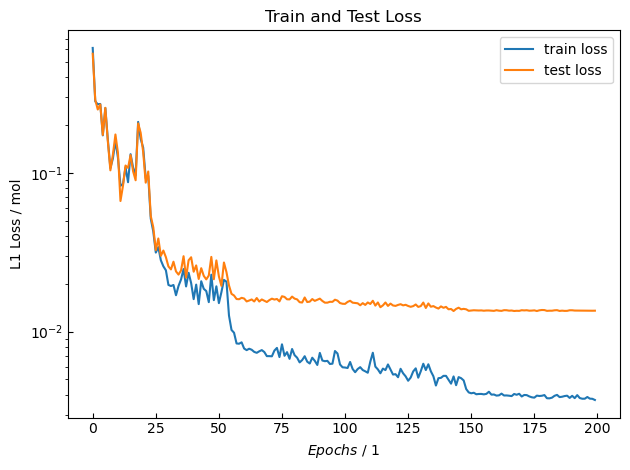

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'L1 Loss / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2 = 0.9999319656078064
Test Dataset: R^2 = 0.9995115489310111
Max Error Training: |xi - xi_pred| = 0.010564592863003902
Max Error Test: |xi - xi_pred| = 0.011211312551272876


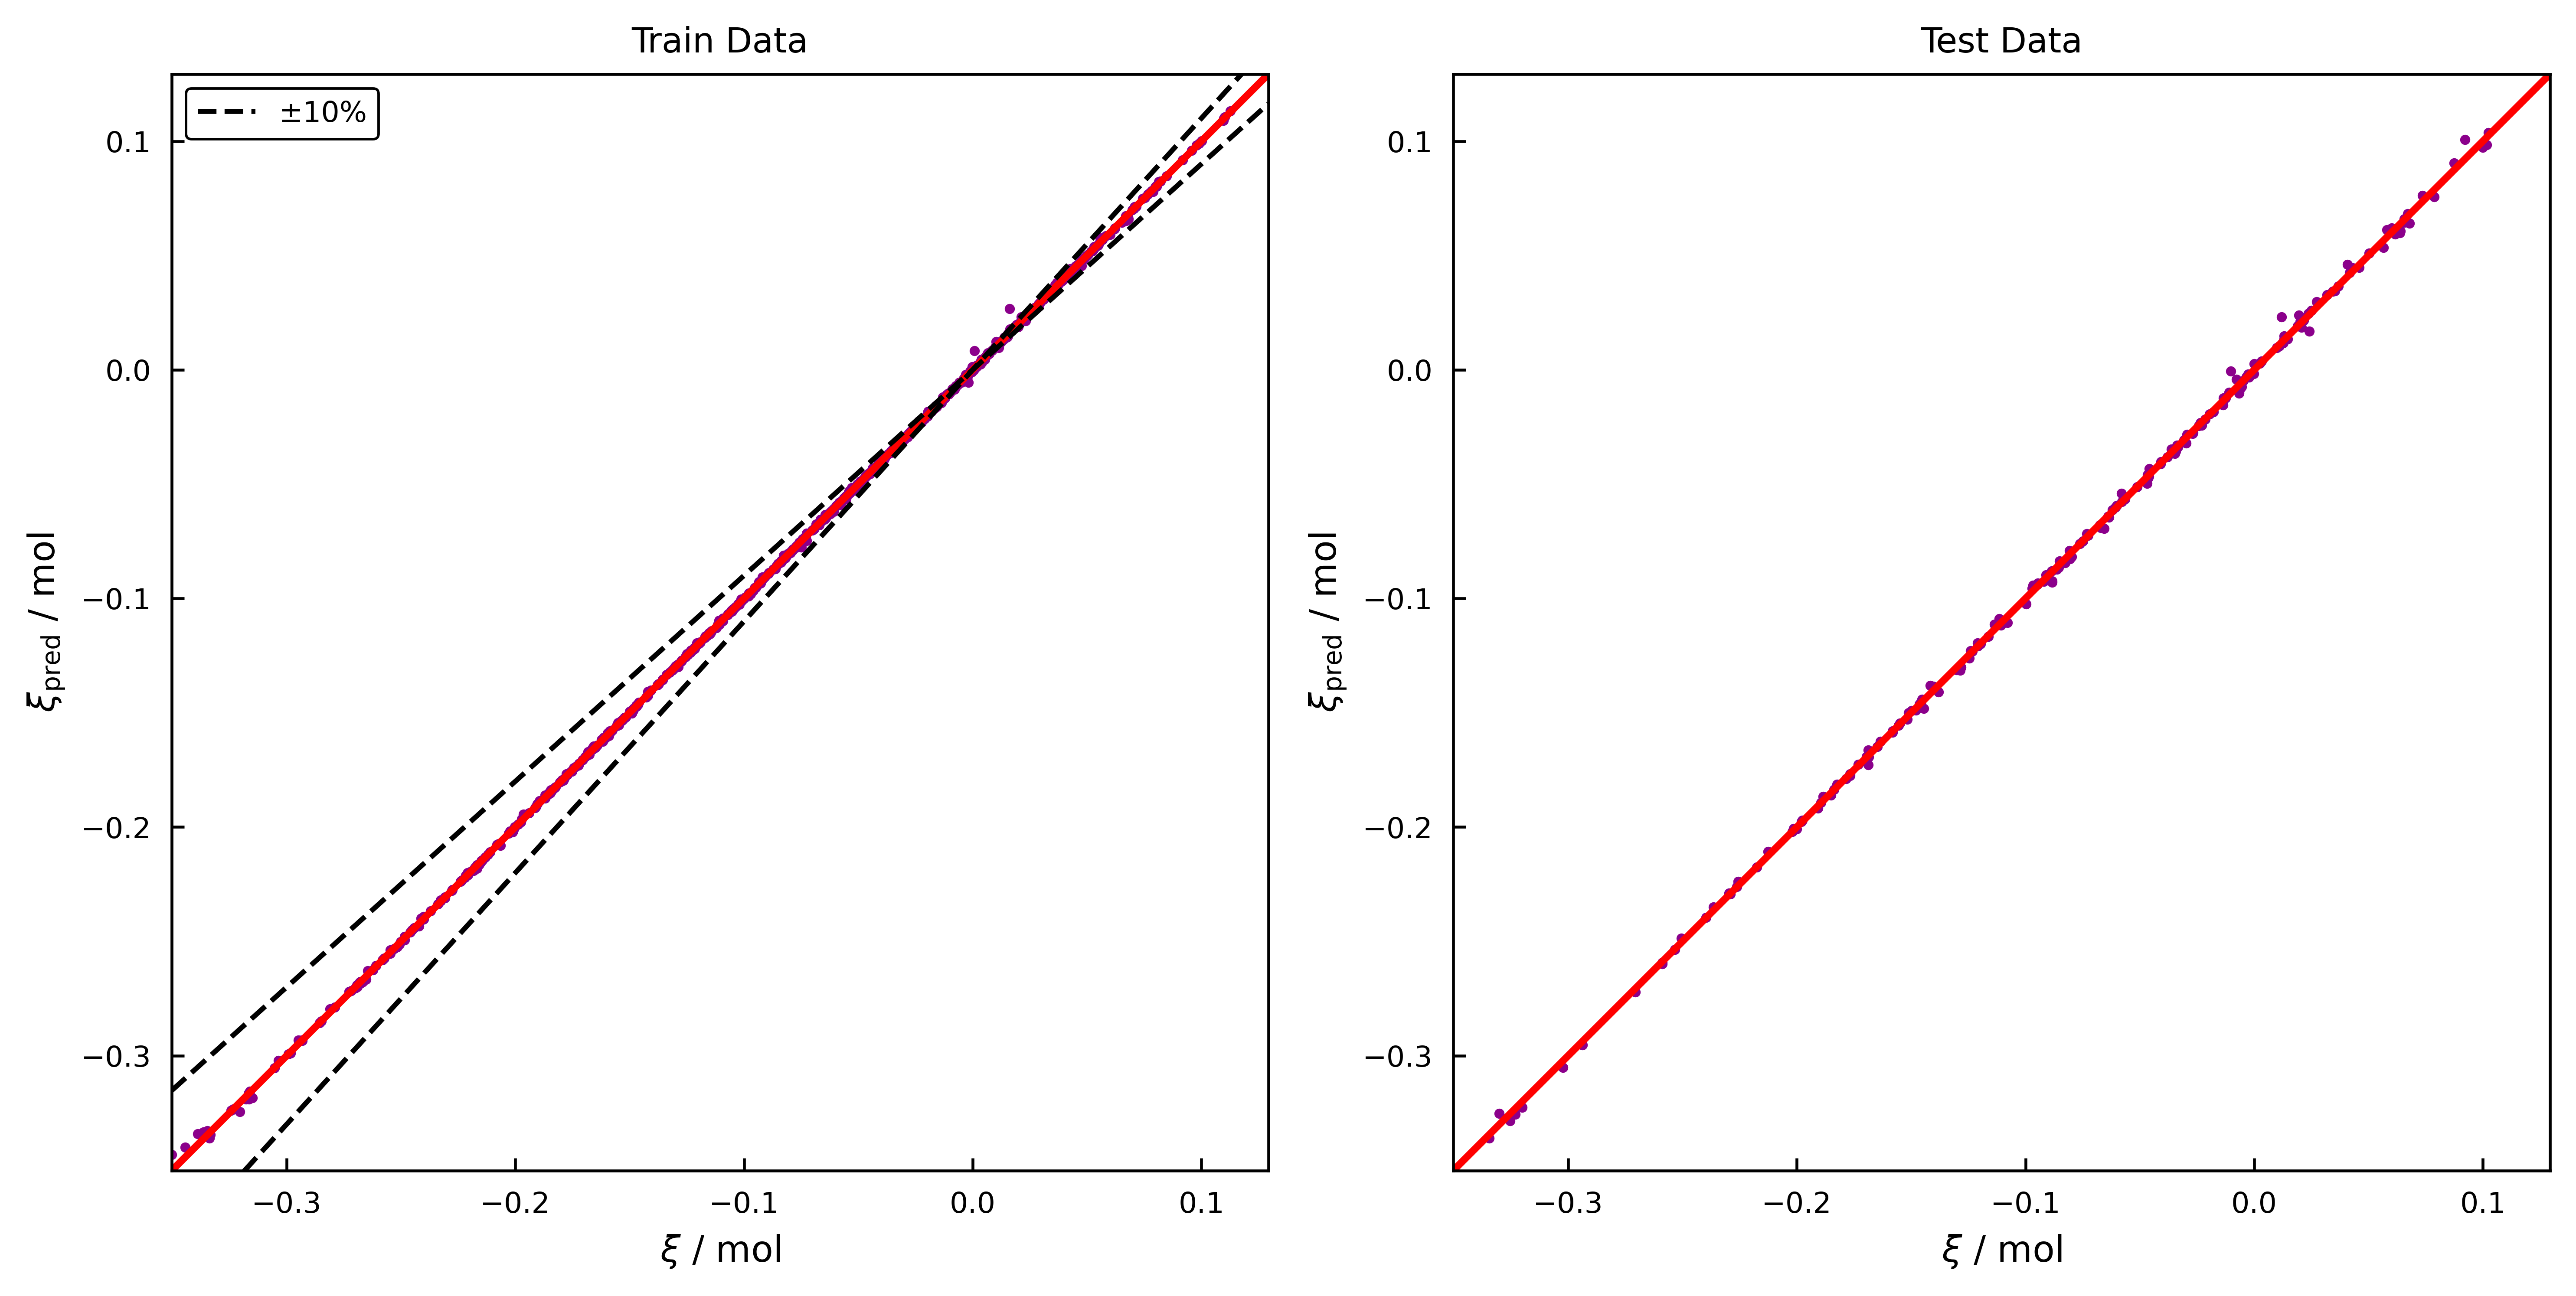

In [24]:
xi_real_norm = []
xi_pred_norm = []
for (X,y) in train_dataloader:
    xi_real_norm = np.append(xi_real_norm, y.numpy())
    xi_pred_norm = np.append(xi_pred_norm, net(X).detach().numpy())

xi_real_test_norm = []
xi_pred_test_norm = []
for (X,y) in test_dataloader:
    xi_real_test_norm = np.append(xi_real_test_norm, y.numpy())
    xi_pred_test_norm = np.append(xi_pred_test_norm, net(X).detach().numpy())

xi_real = xi_real_norm * std_out.numpy() + mean_out.numpy()
xi_pred = xi_pred_norm * std_out.numpy() + mean_out.numpy()
xi_real_test = xi_real_test_norm * std_out.numpy() + mean_out.numpy()
xi_pred_test = xi_pred_test_norm * std_out.numpy() + mean_out.numpy()

print('Training Dataset: R^2 =', r2(xi_real,xi_pred))
print('Test Dataset: R^2 =', r2(xi_real_test,xi_pred_test))
print('Max Error Training: |xi - xi_pred| =', max_error(xi_real, xi_pred))
print('Max Error Test: |xi - xi_pred| =', max_error(xi_real_test, xi_pred_test))

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1]*1.1], "k--", label = ('\xb1' '10%')) # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1]*0.9], "k--") # Error line
# ax[0].text(0.7, 0.9, '+10%')
# ax[0].text(0.8, 0.65, '-10%')
ax[0].set_title('Train Data')
ax[0].legend()

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

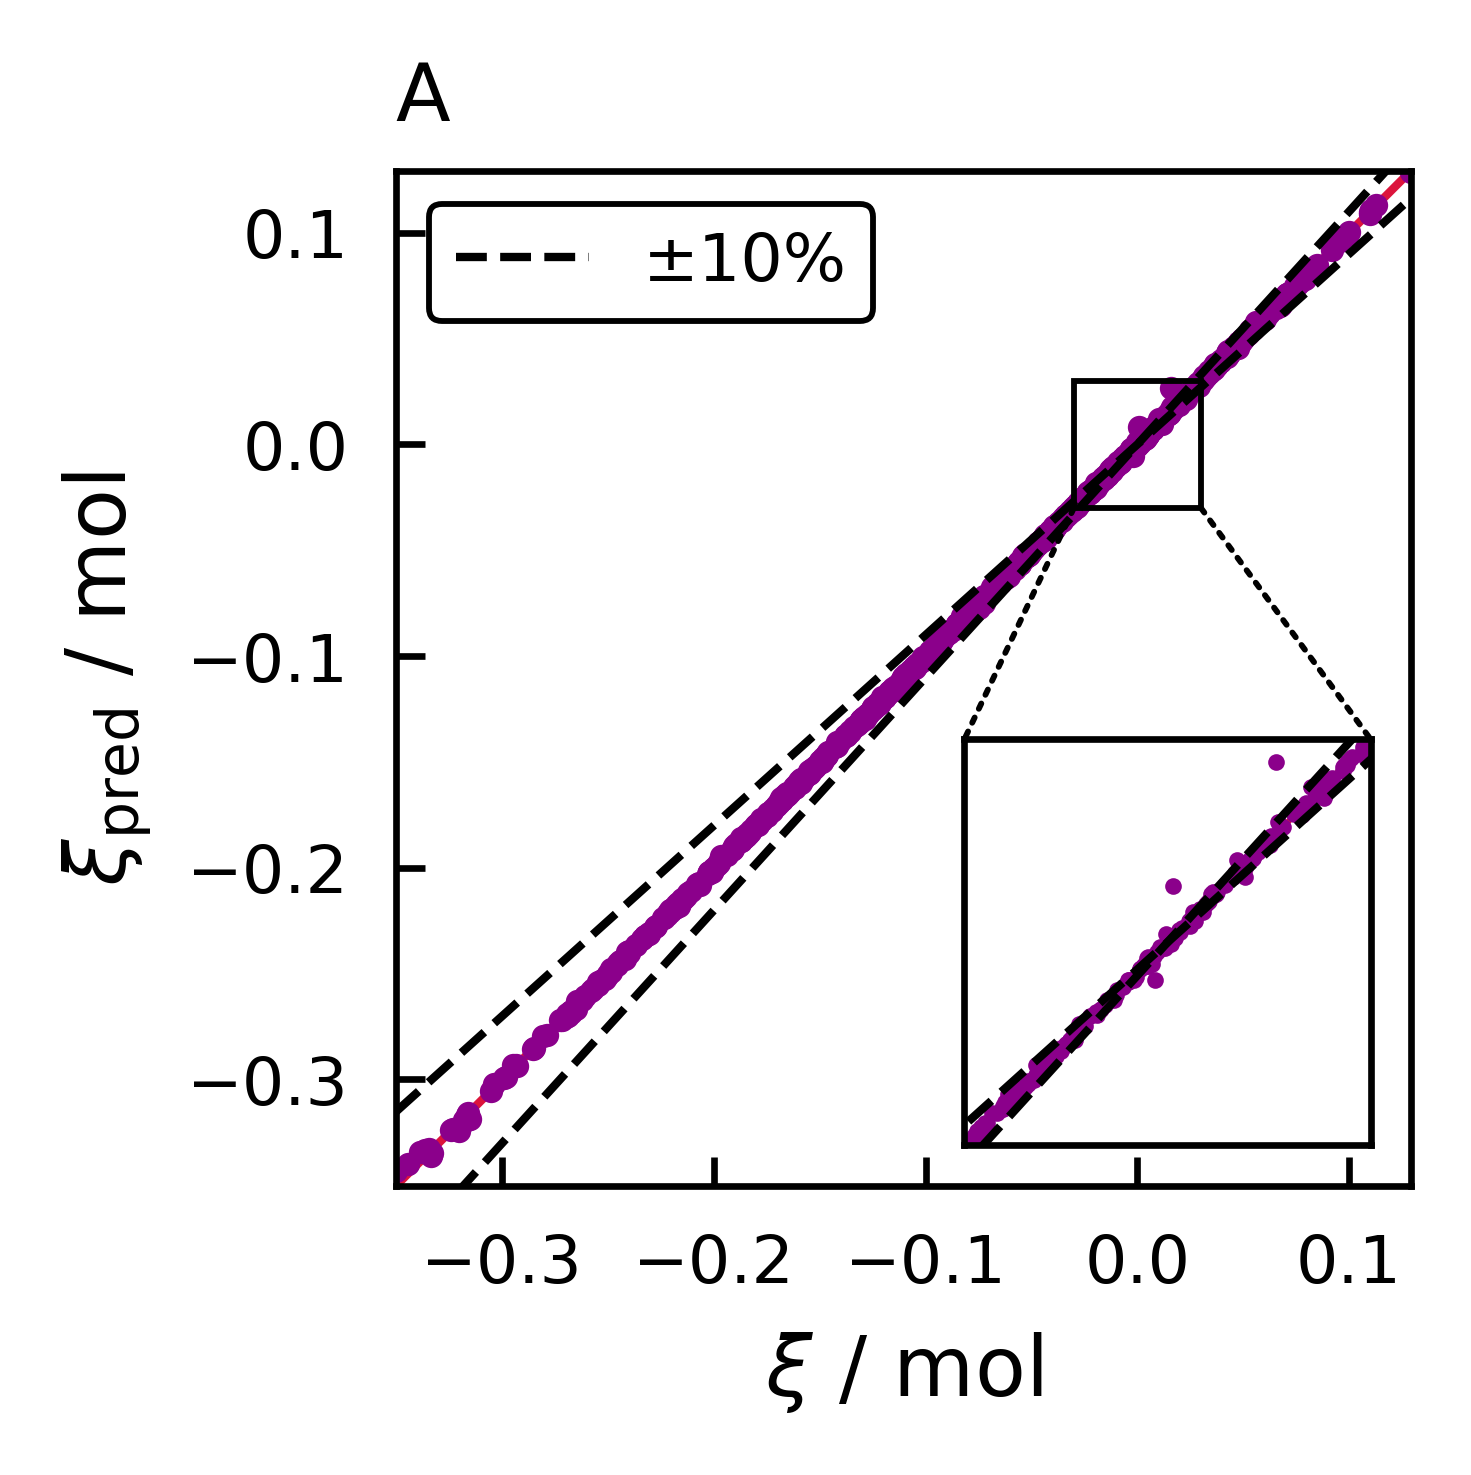

In [67]:
fig,ax = plt.subplots(figsize=(6.5*cm,6.5*cm))

# # Reset the limits
# ax= plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot(xi_real, xi_pred, '.')
ax.plot([0, 1], [0, 1], "-",color='crimson',lw=1 ,transform=ax.transAxes, zorder=1)
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1,label = ('\xb1' '10%')) # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1) # Error line

ax.set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('A',loc='left')
ax.legend()

x1,x2,y1,y2 = -0.03, 0.03, -0.03, 0.03 # subregion of origanal image
axin1 = ax.inset_axes([0.56, 0.04, 0.4, 0.4], xlim=(x1,x2), ylim=(y1,y2), xticks=[], yticks=[], xticklabels=[], yticklabels=[])

axin1.plot(xi_real, xi_pred, '.', markersize = 4)
axin1.plot([0, 1], [0, 1], "-", color = 'crimson',lw=0.7,zorder=1 )
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1)
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1)

rect = (x1, y1, x2 - x1, y2 - y1)
box1= ax.indicate_inset(rect, edgecolor="black", alpha=1,lw=0.7)

cp1 = ConnectionPatch(xyA=(-0.03, -0.03), xyB=(0, 1), axesA=ax, axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)
cp2 = ConnectionPatch(xyA=(0.03, -0.03), xyB=(1, 1), axesA=ax, axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)

ax.add_patch(cp1)
ax.add_patch(cp2)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [68]:
#fig.savefig(Path.cwd() / 'plots/ann/TKA_SRA_PA_016_parity_norm_xi.png', bbox_inches = 'tight')

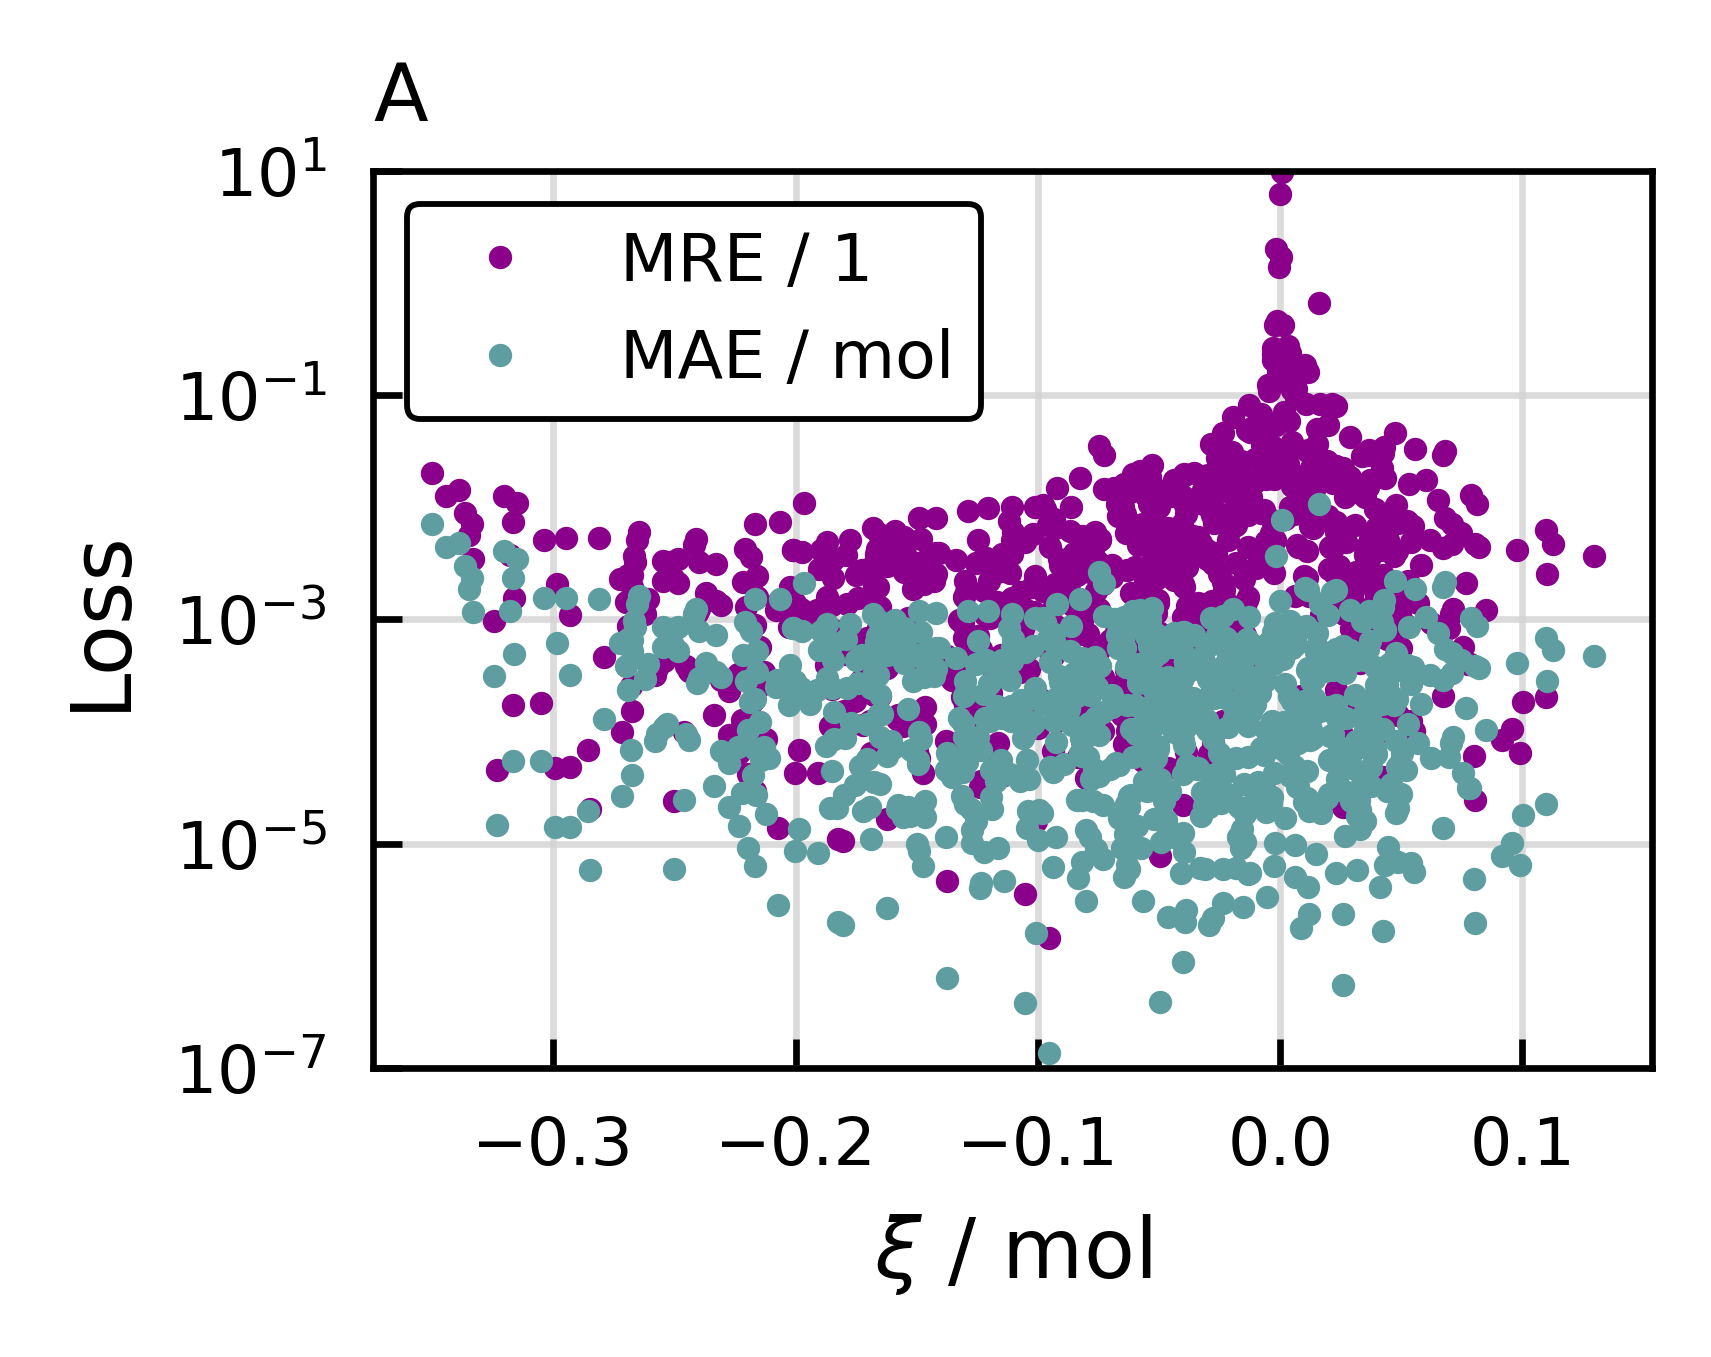

In [65]:
fig,ax = plt.subplots(figsize=(7.5*cm,6*cm))
ax.semilogy(xi_real, abs((xi_pred - xi_real) / xi_real), '.', label = 'MRE / 1')
ax.semilogy(xi_real, abs(xi_real-xi_pred), '.', label = 'MAE / mol')
ax.set(xlabel = '$\\xi$ / mol', ylabel = 'Loss')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
#ax.yaxis.set_major_locator(mticker.LogLocator(numticks=999))
#ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax.set(ylim=(1e-7,10))
ax.grid(zorder=0)
ax.set_title('A', loc='left')

plt.legend()
plt.tight_layout()
plt.show()

In [66]:
#fig.savefig(Path.cwd() / 'plots/ann/TKA_SRA_PA_017_loss_xi.png', bbox_inches = 'tight')

#### Plot Fehler vs Epoch

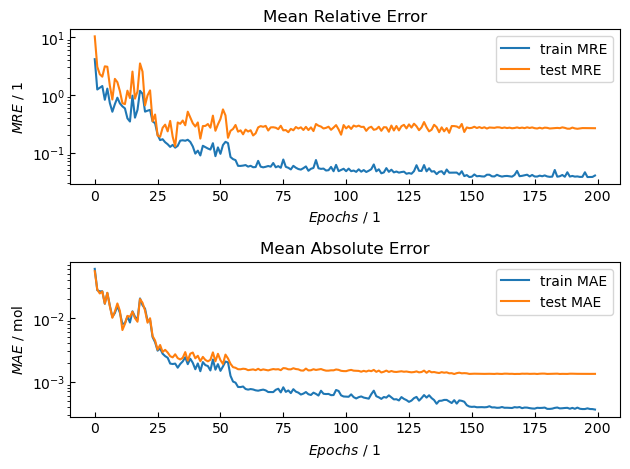

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()


plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

T: 0.5084896512459315
T: 780.873416256059


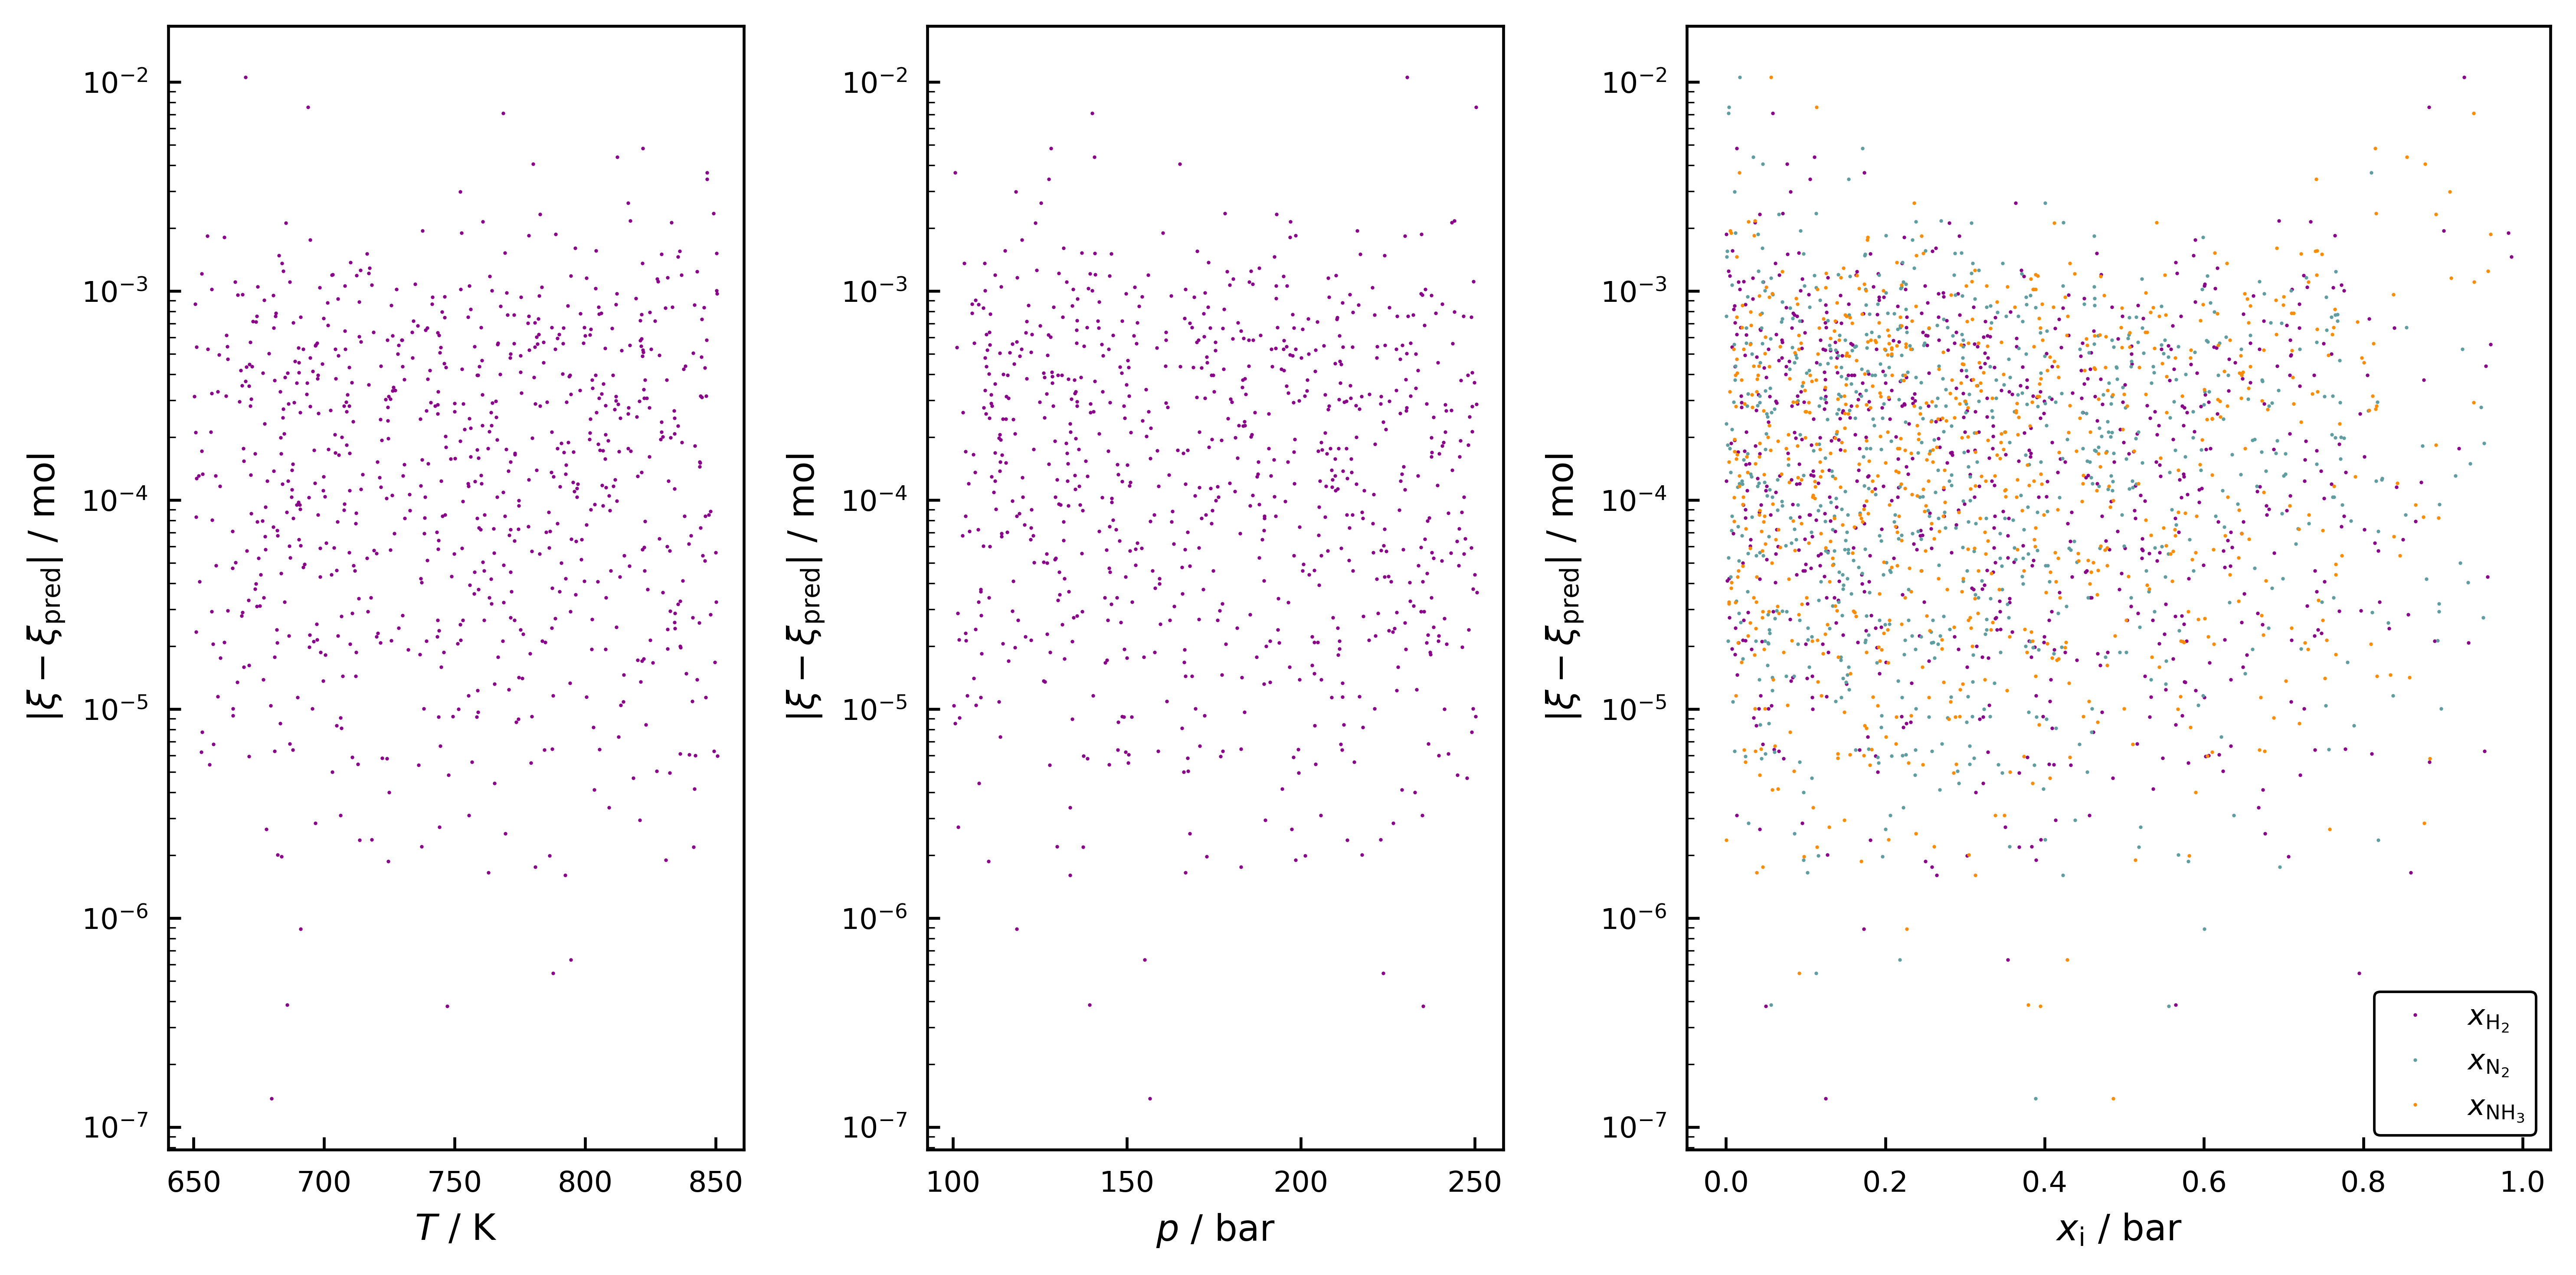

In [40]:
#mistake = []
xi_real_norm = []
xi_pred_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_norm = []
param_x_N2_norm = []
param_x_NH3_norm = []
for X,y in train_dataloader:
    #mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    xi_real_norm = np.append(xi_real_norm, y)
    xi_pred_norm = np.append(xi_pred_norm, net(X).detach().numpy())
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_norm = np.append(param_x_H2_norm, X[:,2])
    param_x_N2_norm = np.append(param_x_N2_norm, X[:,3])
    param_x_NH3_norm = np.append(param_x_NH3_norm, X[:,4])
    
print('T:', param_T_norm[0])
xi_real = xi_real_norm * std_out.numpy() + mean_out.numpy()
xi_pred = xi_pred_norm * std_out.numpy() + mean_out.numpy()
param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2 = param_x_H2_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2 = param_x_N2_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3 = param_x_NH3_norm * std_in[4].numpy() + mean_in[4].numpy()

mistake = abs(xi_real - xi_pred)
print('T:', param_T[0])

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].semilogy(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
#ax[0].set(ylim=(0,max(mistake)))


ax[1].semilogy(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].semilogy(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].semilogy(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].semilogy(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{i}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

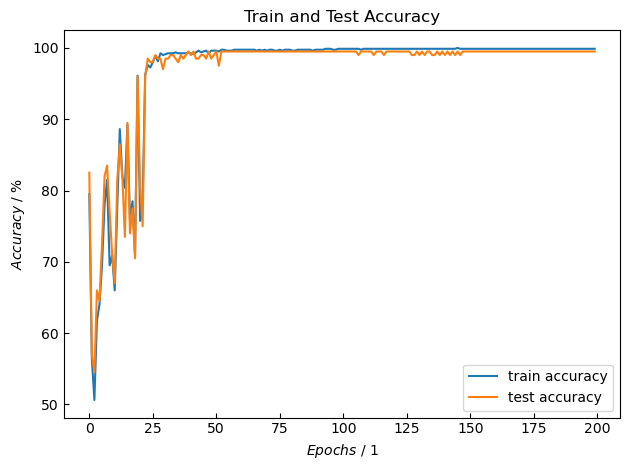

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[ 0.8776, -1.0919, -1.3314,  0.7887,  0.5833],
        [-1.0600, -1.2703, -0.6513,  1.7195, -1.0211],
        [ 0.1906,  0.7674, -0.7398, -0.6178,  1.3586],
        [ 0.1255,  0.1532, -0.0615, -0.8617,  0.9067],
        [ 1.2022, -0.7077,  0.3980, -0.7766,  0.3554],
        [ 1.4499, -1.3133,  1.5113, -1.1824, -0.3809],
        [-0.4641, -1.6367, -1.3372,  2.4689, -1.0567],
        [-1.4729,  1.2057, -1.3234,  2.1129, -0.7220],
        [ 0.2125,  0.0539, -1.0131,  2.4757, -1.3934],
        [ 0.0624,  0.0928, -0.8430, -0.3310,  1.1828],
        [ 0.5426,  0.4132, -1.2612, -1.1138,  2.3755],
        [ 0.4935, -0.2255, -1.1196, -1.2018,  2.3175],
        [ 1.2297,  0.1228,  0.6124, -1.1599,  0.5125],
        [ 1.4182,  0.7505,  1.9738, -0.8123, -1.2143],
        [ 1.0922,  0.0096, -0.8909, -0.7159,  1.6086],
        [-0.3140, -0.7682, -1.0406,  1.9245, -0.8255],
        [-1.0279,  1.7289,  2.2408, -1.3850, -0.9254],
        [ 0.7918, -0.0228,  1.0500, -0.6272, -0.4549],
        [-

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 2.7196e-01,  1.4790e-01, -1.5376e-01, -9.7017e-02, -3.9367e-01],
         [-1.7795e-01,  2.0404e-01, -3.7541e-01, -2.6891e-01, -1.8846e-01],
         [-3.2881e-01, -1.5045e-01, -3.2908e-02,  2.1665e-01, -1.2339e-01],
         [ 3.6899e-01,  3.0470e-01, -2.9879e-01,  1.1729e-01,  3.2273e-01],
         [-8.3055e-02,  2.2122e-01,  3.7940e-01, -1.8308e-01, -1.3541e-01],
         [-3.7502e-01,  3.5605e-01,  2.0759e-01, -1.2624e-02, -2.3440e-01],
         [ 2.2995e-01,  1.1316e-01, -2.9256e-01,  3.5969e-01, -4.4105e-01],
         [ 1.0155e-01,  1.0413e-01,  3.3073e-02,  3.6663e-01, -2.7889e-01],
         [-3.7442e-01,  1.7176e-01, -3.2500e-01,  2.8088e-01,  2.9383e-01],
         [-1.1212e-01,  7.0088e-02,  1.2691e-02, -2.7957e-01,  2.5697e-02],
         [-2.9308e-01, -2.8562e-01, -1.1443e-01,  3.1174e-01, -3.1408e-01],
         [-9.9249e-02, -3.1216e-01,  3.0275e-01,  8.8179e-02,  1.9264e-01],
         [ 3.1357e-01,  4.4310e-02, -1.5545e-01, -1.9602e-01,  1.

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.7464, 0.7188, 0.7697, 0.6378, 0.8409],
        [0.0638, 0.5845, 0.0356, 0.3196, 0.0090]])
tensor([[-0.1211],
        [ 0.2016]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-0.1361, -1.3476,  0.4731,  0.5717, -1.0419],
        [ 1.6182,  1.2586, -0.8616,  2.2016, -1.2792],
        [ 0.9117,  0.2967, -1.0901,  2.4798, -1.3190],
        [ 1.6567, -0.0820, -1.2390,  0.7236,  0.5530],
        [ 0.4935, -0.2255, -1.1196, -1.2018,  2.3175],
        [ 0.2737, -0.4963, -0.5410,  0.9670, -0.3963],
        [-1.1955,  0.2434, -1.4256, -1.2244,  2.6512],
        [-0.1056, -0.4742, -0.2990, -1.2846,  1.5629],
        [-0.1223,  1.5859,  0.0489,  1.2532, -1.2774],
        [ 1.6605,  0.3328,  0.5294, -0.2956, -0.2496],
        [-0.7403, -0.0364,  0.9137, -0.4419, -0.4976],
        [ 1.3564, -0.0154, -1.0418,  1.4744, -0.3833],
        [-1.3807, -0.3611, -0.7253,  0.2133,  0.5297],
        [ 1.1360, -1.5053,  1.8803, -1.1818, -0.7572],
        [-0.7425,  1.5341, -0.9317, -0.2479,  1.1917],
        [-0.2670, -0.9863,  0.9838, -0.7414, -0.2756],
        [-1.2344, -1.1919, -0.4222, -0.5671,  0.9854],
        [ 1.4003, -1.4790, -1.1669,  0.9685,  0.2397],
        [-

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()